# Personal Financial Planning

In [35]:
import pandas as pd
from datetime import date
import numpy as np
from collections import OrderedDict
from dateutil.relativedelta import *
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

# pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('precision',5)
pd.set_option('display.max_colwidth',100)
pd.options.mode.chained_assignment = None  # default='warn'

%matplotlib inline
plt.style.use('ggplot')

# References

This analysis is based on and expands the models developed in Chris Moffit's [blog](http://pbpython.com/amortization-model-revised.html  )

http://pbpython.com/amortization-model-revised.html  
https://jeffknupp.com/blog/2013/04/07/improve-your-python-yield-and-generators-explained/  
https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.financial.html  
http://inmachineswetrust.com/posts/understanding-generators/#cell3

## Generators

The summary shown here is an extraction from Jeff Knupp's [blog](https://jeffknupp.com/blog/2013/04/07/improve-your-python-yield-and-generators-explained/).

A generator is a function that uses the `yield` keyword (once or more times), which yields a value back to the calling function, the `yield` saves/retains its internal state, and on the next call starts immediately after the line with the `yield` keyword.  This allows the generator to act as a special type of iterator. The generator may have a return keyword (including an implicit `return None` at the end of the function), which terminates the function, destroying all internal state.  When `yield` is encountered some value and flow control is given back to the calling function, but state and current line of execution is kept for use during future calls. Subsequent calls will continue on the line after the `yield` keyword, using the state left behind from the previous call.

In [36]:
def simple_generator_function():
    yield 1
    yield 2
    yield 3

An iterator is an object that provides a series of values when its internal `next()` function is called. Iterator objects can also be used in `for` statements (which calls the `next()` function implicitly).

In [37]:
for value in simple_generator_function():
    print(value)

1
2
3


In [38]:
our_generator = simple_generator_function()
print(next(our_generator))
print(next(our_generator))
print(next(our_generator))


1
2
3


If a generator function calls `return` or reaches the end its definition, a `StopIteration` exception is raised. This signals to whoever was calling `next()` that the generator is exhausted (this is normal iterator behavior).


In [39]:
our_generator = simple_generator_function()
for value in our_generator:
    pass
print(next(our_generator))

StopIteration: 

Create a new generator by calling the generator function again:

In [40]:
new_generator = simple_generator_function()
print(next(new_generator)) # perfectly valid

1


The following example calculates prime numbers using a generator function.
Note that `yield` is only executed if the number is prime, return the prime value and control back to the iterator (`get_primes`). 

The prime calculation is enclosed in a `while True:` conditional to not fall through to the implied `return None` at the end of the function. This is a fairly common idiom in generators: the function seldom reaches an explicit or implied `return` statement.


In [41]:
def is_prime(number):
    if number > 1:
        if number == 2:
            return True
        if number % 2 == 0:
            return False
        for current in range(3, int(np.sqrt(number) + 1), 2):
            if number % current == 0: 
                return False
        return True
    return False

def get_primes(number):
    while True and number < 19:
        if is_prime(number):
            yield number
        number += 1
    # all functions implicitly returns None, but it is never reached here:
    return None 
        
        

In [42]:
for prime in get_primes(7):
    print(prime)
    if prime > 11:
        break

7
11
13


In [43]:
our_generator = get_primes(7)
print(next(our_generator))
print(next(our_generator))
print(next(our_generator))

7
11
13


Since Pandas 0.19 a generator can be used to initialise the values in a DataFrame.  
https://stackoverflow.com/questions/18915941/create-a-pandas-dataframe-from-generator  
https://codereview.stackexchange.com/questions/162402/importing-database-of-4-million-rows-into-pandas-dataframe


In [72]:
pd.DataFrame(get_primes(7))

,0
0,7
1,11
2,13
3,17


List comprehensions are a convenient way to construct a customized list object. For example, let's create a list containing the cubes of even integers between 0 and 20 inclusive and display each element.

In [67]:
cubes_list = [x ** 3 for x in range(21) if x % 2 == 0]

for i in cubes_list:
    print(i, end=' ')

0 8 64 216 512 1000 1728 2744 4096 5832 8000 

If we swap out the brackets for parentheses in the list comprehension, we have a generator expression, which produces a generator that successively yields the same sequence of numbers. It's very important to note that a generator expression is not a tuple comprehension. That is, a generator expression yields a generator object, not a tuple object.

In [68]:
cubes_gen = (x ** 3 for x in range(21) if x % 2 == 0)

for i in cubes_gen:
    print(i, end=' ')

0 8 64 216 512 1000 1728 2744 4096 5832 8000 

There is a lot more to generators, see Knupp's blog and Google.

## Simple Financial Calculations

In [44]:
Interest_Rate = 0.04
Years = 30
Payments_Year = 12
Principal = 200000
start_date = (date(2000,1,1))

How large a monthly payment is required to repay bond?

In [45]:
pmt = np.pmt(Interest_Rate/Payments_Year, Years*Payments_Year, Principal)
print(f'Payment required {pmt}')

Payment required -954.8305909309076


How much interest or capital is paid in a specific period (a month in this case)

In [46]:
# Period/month for which to calculate
per = 240

# Calculate the interest
ipmt = np.ipmt(Interest_Rate/Payments_Year, per, Years*Payments_Year, Principal)

# Calculate the principal
ppmt = np.ppmt(Interest_Rate/Payments_Year, per, Years*Payments_Year, Principal)

print(f'Interest {ipmt}, capital {ppmt}')


Interest -316.49041533656924, capital -638.3401755943385


## Moffit's Amortisation Model

This model and code is taken from http://pbpython.com/amortization-model-revised.html. Moffit was looking for a way to do amortisation  calculations in Pandas without loops, but ended up using a generator function to do the looping.  The generator does a complete set of loops and then provides the answer to a Pandas DataFrame.   The power of Pandas is therefore not available during the loop, but it is available afterwards for analysis and plotting.

Moffit's code is refactored and cleaned up. The additional payment must now be expressed as a percentage of the minimum required payment.

**A note on dates:**  The default start date in this notebook is 2000-01-01, mainly because it is easy to calculate the term remaining from a round number.  The date 0000-01-01 is not allowed in the Python code, so I start with the year 2000.

Build a payment schedule using a generator that can be easily read into a pandas dataframe.

In [73]:
def amortize(principal, interest_rate, years, pmt, addl_payment, start_date, annual_payments):
    """
    Calculate the amortization schedule given the loan details.

    :param principal: Amount borrowed
    :param interest_rate: The annual interest rate for this loan
    :param years: Number of years for the loan
    :param pmt: Payment amount per period
    :param addl_payment: Additional payments to be made each period.
    :param start_date: Start date for the loan.
    :param annual_payments: Number of payments in a year.

    :return: 
        schedule: Amortization schedule as an Ordered Dictionary
    """

    # initialize the variables to keep track of the periods and running balances
    p = 1
    beg_balance = principal
    end_balance = principal
    
    while end_balance > 0:
        
        # Recalculate the interest based on the current balance
        interest = round(((interest_rate/annual_payments) * beg_balance), 2)
        
        # Determine payment based on whether or not this period will pay off the loan
        pmt = min(pmt, beg_balance + interest)
        
        # Ensure additional payment gets adjusted if the loan is being paid off
        addl_payment = min(addl_payment, beg_balance - (pmt - interest))
        end_balance = beg_balance - (pmt - interest + addl_payment)

        yield OrderedDict([('Month',start_date),
                           ('Period', p),
                           ('Begin Balance', beg_balance),
                           ('Payment', pmt),
                           ('Principal', principal),
                           ('Interest', interest),
                           ('AddPayment', addl_payment),
                           ('End Balance', end_balance)])
        
        # Increment the counter, balance and date
        p += 1
        start_date += relativedelta(months=1)
        beg_balance = end_balance

Confirm that the `amortize` function is a generator:

In [76]:
amortize(principal=10000, interest_rate=.03, years=5, pmt=400, addl_payment=0, start_date=date(2000, 1,1), annual_payments=12)

<generator object amortize at 0x000000000990F7D8>

Next create a wrapper function to use `amortize` to fill a Pandas DataFrame.  This function primarily cleans up the table and provides summary stats so it is easy to compare various scenarios.



In [79]:
def amortization_table(principal, interest_rate, years,
                       addpayment=0, annual_payments=12, start_date=(date(2000,1,1))):
    """
    Calculate the amortization schedule given the loan details as well as summary stats for the loan

    :param principal: Amount borrowed
    :param interest_rate: The annual interest rate for this loan
    :param years: Number of years for the loan
    
    :param annual_payments (optional): Number of payments in a year. Default 12.
    :param addpayment (optional): Additional payments to be made each period as percentage of required payment. Default 0.
    :param start_date (optional): Start date. Default first of next month if none provided

    :return: 
        schedule: Amortization schedule as a pandas dataframe
        summary: Pandas dataframe that summarizes the payoff information
    """
    
    # Payment stays constant based on the original terms of the loan
    payment = -round(np.pmt(interest_rate/annual_payments, years*annual_payments, principal), 2)
    if addpayment != 0:
        addpayment = payment * addpayment / 100
    
    # Generate the schedule 
    schedule = pd.DataFrame(amortize(principal, interest_rate, years, payment,
                                     addpayment, start_date, annual_payments))
    # reorder the columns
    schedule = schedule[["Period", "Month", "Begin Balance", "Payment", "Interest", 
                         "AddPayment", "End Balance"]]
    
    # Convert to a datetime object to make subsequent calcs easier
    schedule["Month"] = pd.to_datetime(schedule["Month"])
    
    #Create a summary statistics table
    payoff_date = schedule["Month"].iloc[-1]
    stats = pd.Series([payoff_date, schedule["Period"].count(), interest_rate,
                       years, payment, addpayment,
                       schedule["Interest"].sum()],
                       index=["Payoff Date", "Num Payments", "Interest Rate", "Years", 
                             "Payment", "AddPayment", "Total Interest"])
    
    return schedule, stats

Example showing how to call the function

In [80]:
df, stats = amortization_table(
    principal=700000, 
    interest_rate=.04, 
    years=30, 
    addpayment=2,
    annual_payments=12, 
    start_date=date(2000, 1,1))

In [81]:
stats

Payoff Date       2028-11-01 00:00:00
Num Payments                      347
Interest Rate                    0.04
Years                              30
Payment                        3341.9
AddPayment                     66.838
Total Interest             4.8171e+05
dtype: object

In [82]:
df.head()

,Period,Month,Begin Balance,Payment,Interest,AddPayment,End Balance
0,1,2000-01-01,700000.0000,3341.91,2333.33,66.8382,698924.5818
1,2,2000-02-01,698924.5818,3341.91,2329.75,66.8382,697845.5836
2,3,2000-03-01,697845.5836,3341.91,2326.15,66.8382,696762.9854
3,4,2000-04-01,696762.9854,3341.91,2322.54,66.8382,695676.7772
4,5,2000-05-01,695676.7772,3341.91,2318.92,66.8382,694586.9490


In [83]:
df.tail()

,Period,Month,Begin Balance,Payment,Interest,AddPayment,End Balance
342,343,2028-07-01,15762.9256,3341.9100,52.54,66.8382,12406.7174
343,344,2028-08-01,12406.7174,3341.9100,41.36,66.8382,9039.3292
344,345,2028-09-01,9039.3292,3341.9100,30.13,66.8382,5660.7110
345,346,2028-10-01,5660.7110,3341.9100,18.87,66.8382,2270.8328
346,347,2028-11-01,2270.8328,2278.4028,7.57,0.0000,0.0000


## Bond Repayment Studies

Define a few standard utility functions

In [53]:
def plot_balance(scenarios):
    """Plot the remaining balance of all scenarios
    """
    fig, ax = plt.subplots(1, 1)
    for scenario in scenarios.keys():
        schedules[scenario].plot(x='Month', y='End Balance', label=f'{scenario}', ax=ax)
    plt.title("Pay Off Timelines");
    plt.ylabel("Balance");

In [54]:
def plot_annual_interest(schedule, stats):
    """Plot the annual interest of all scenarios
    """
    ys = {}
    labels = {}
    for scenario in scenarios.keys():
        ys[scenario],labels[scenario] = annual_interest(schedules[scenario], stats[scenario])

    dfai = pd.concat([ys[scenario] for scenario in ys.keys()], axis=1)
    # print(dfai)

    figsize(7,5)
    fig, ax = plt.subplots(1, 1)
    dfai.plot(kind="bar", ax=ax)

    plt.legend([labels[scenario] for scenario in labels.keys()], loc=1, prop={'size':10})
    plt.title("Interest Payments");

In [55]:
def annual_interest(schedule, stats):
    """Create a dataframe with annual interest totals, and a descriptive label
    """
    annint = schedule.set_index('Month')['Interest'].resample("A").sum().reset_index()
    annint["Year"] = annint["Month"].dt.year
    annint.set_index('Year', inplace=True)
    annint.drop('Month', 1, inplace=True)
    label="{} years at {}% with additional payment of {:.0f}".format(stats['Years'], stats['Interest Rate']*100, stats['AddPayment'])
    return annint, label



In [56]:
def calc_scenarios(scenarios):
    """Given a scenario dictionary calculate bond schedules and statistics
    """
    schedules = {}
    stats = {}
    for scenario in scenarios.keys():
        schedules[scenario], stats[scenario] = amortization_table(
                                            scenarios[scenario]['princ'], 
                                            scenarios[scenario]['intr'], 
                                            scenarios[scenario]['years'], 
                                            scenarios[scenario]['addprinc']
        )
    return schedules,stats


### Mixed scenarios

Compare different scenarios with different additional payments.

In [57]:
scenarios = {
    'Scenario 1':{'princ':100000,'intr':0.04,'addprinc':5,'years':30},
    'Scenario 2':{'princ':100000,'intr':0.05,'addprinc':10,'years':30},
    'Scenario 3':{'princ':100000,'intr':0.04,'addprinc':0,'years':15},
}
        
schedules,stats = calc_scenarios(scenarios) 

Review the summary results for the different scenarios:

In [58]:
pd.DataFrame([stats[key] for key in stats.keys()])

,Payoff Date,Num Payments,Interest Rate,Years,Payment,AddPayment,Total Interest
0,2027-05-01,329,0.04,30,477.42,23.871,64718.90
1,2024-07-01,295,0.05,30,536.82,53.682,73665.87
2,2014-12-01,180,0.04,15,739.69,0.000,33143.79


The scenario time lines

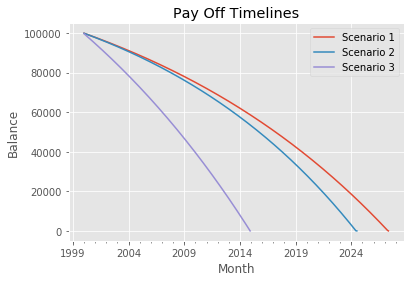

In [59]:
plot_balance(scenarios)

Plot the annual interest for the different scenarios

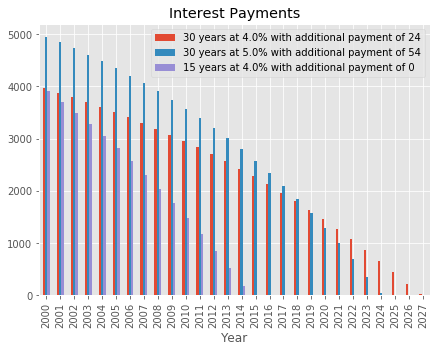

In [60]:
plot_annual_interest(schedules, stats)   

### Fixed scenario, different additional payments

In [61]:
scenarios = {
    '0.04%, add=0, 30 years':{'princ':100000,'intr':0.04,'addprinc':0,'years':30},
    '0.04%, add=50, 30 years':{'princ':100000,'intr':0.04,'addprinc':2,'years':30},
    '0.04%, add=200, 30 years':{'princ':100000,'intr':0.04,'addprinc':10,'years':30},
    '0.04%, add=500, 30 years':{'princ':100000,'intr':0.04,'addprinc':20,'years':30},
}
        
schedules,stats = calc_scenarios(scenarios) 

In [62]:
pd.DataFrame([stats[key] for key in stats.keys()])

,Payoff Date,Num Payments,Interest Rate,Years,Payment,AddPayment,Total Interest
0,2029-12-01,360,0.04,30,477.42,0.0000,71867.97
1,2028-11-01,347,0.04,30,477.42,9.5484,68813.48
2,2025-03-01,303,0.04,30,477.42,47.7420,58932.25
3,2021-10-01,262,0.04,30,477.42,95.4840,50098.82


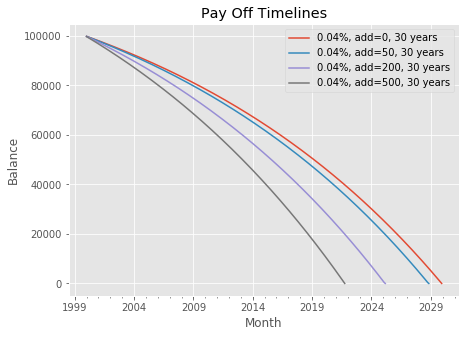

In [63]:
plot_balance(scenarios)

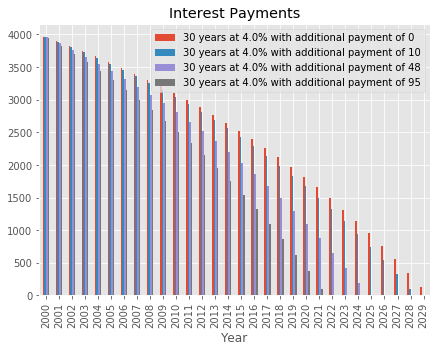

In [64]:
plot_annual_interest(schedules, stats)   

## Time Value of Money

Inflation erodes the buying power of money over time.  As long as your salary keeps track, or exceeds, of inflation, the erosion effect might not be very noticeable. However, if your salary increases slower than inflation, your buying power decreases with time.

From the table below it is evident that the value of money halves in 11.5 years if the inflation rate is 6%.

In [65]:
df = pd.DataFrame()
df['Inflation %'] =  np.linspace(3,15,13)
df['Years-to-half'] = -np.log(0.5)/np.log(1+df['Inflation %']/(100*12))/12
df

,Inflation %,Years-to-half
0,3.0,23.13378
1,4.0,17.35754
2,5.0,13.89180
3,6.0,11.58131
4,7.0,9.93096
5,8.0,8.69319
6,9.0,7.73048
7,10.0,6.96031
8,11.0,6.33018
9,12.0,5.80506


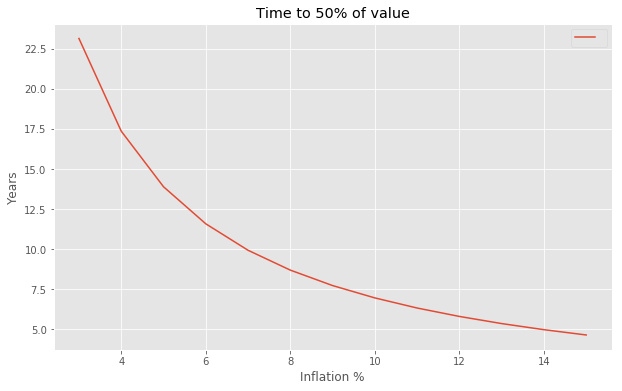

In [66]:
figsize(10,6)
fig, ax = plt.subplots(1, 1)
df.plot(x='Inflation %', y='Years-to-half', label=f'', ax=ax)
plt.title("Time to 50% of value");
plt.ylabel("Years");

Suppose it is possible to freeze the time value of money, to always remain at unity.  With the time value of money frozen, we can evaluate the value of asset growth and costs in a manner decoupled from the erosion effect of inflation: we evaluate the investment or cost in terms of  true buying power.  The money value would always have constant buying power irrespective of time into the future.

Freezing the time value of money is readily done by considering any costs or growth relative to the inflation rate. If the inflation rate is 6% and an investment realises 8% growth, the real growth (corrected for inflation) is 2%.  Hence the effect of inflation on time value of money can be removed by considering all costs and growth relative to inflation: just subtract inflation rate.
